# Import Model

In [2]:
from python_scripts.pretrain_model import PretrainedEncoderRegressor
import torch.nn as nn

name = 'AE_Center_noaug'

checkpoint_path = f"AE_model/128/{name}/best.pt"

# 1) ÂÆû‰æãÂåñÔºà‰ºöËá™Âä®Âä†ËΩΩÂπ∂ÂÜªÁªì encoderÔºâ
model = PretrainedEncoderRegressor(
    ae_checkpoint=checkpoint_path,
    ae_type="center",
    tile_dim=128,
    center_dim=128,
    neighbor_dim=128,
    output_dim=35
)

# 2) monkey‚Äêpatch ‰∏Ä‰∏™Êñ∞ÁöÑ head
model.decoder  = nn.Sequential(
    nn.Linear(128+128+128, 256),
    nn.LeakyReLU(0.01),
    nn.Dropout(0.1),
    nn.Linear(256, 128),
    nn.LeakyReLU(0.01),
    nn.Dropout(0.1),
    nn.Linear(128, 64),
    nn.LeakyReLU(0.01),
    nn.Dropout(0.1),
    nn.Linear(64, 35)
    
)

# 3) ÂÜçÊ¨°Ê£ÄÊü•Âè™ËÆ≠ÁªÉ head
# for name, p in model.named_parameters():
#     print(name, p.requires_grad)



# ‚Äî‚Äî 5) Á°Æ‰øùÂè™Êúâ decoder ÂèØËÆ≠ÁªÉ ‚Äî‚Äî  
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable / total params = {trainable:,} / {total:,}")


Trainable / total params = 141,987 / 6,679,843


## Load Model

# Import training data

## Same in multiple .pt

In [3]:
import os
import torch
import random
import inspect
from python_scripts.import_data import load_all_tile_data

# Áî®Ê≥ïÁØÑ‰æã
#folder = "dataset/spot-rank/version-3/only_tile_sub/original_train"
folder = "dataset/spot-rank/filtered_directly_rank/masked/no_realign/Macenko_masked/filtered/train_data/"

grouped_data = load_all_tile_data( 
        folder_path=folder,
        model=model,
        fraction=1,
        shuffle=False
    )

    # grouped_data ÁèæÂú®Âè™ÊúÉÊúâ model.forward() ÈúÄË¶ÅÁöÑ keyÔºå
    # ÂÉè ['tile','subtiles','neighbors','norm_coord','node_feat','adj_list','edge_feat','label','source_idx']
print("Loaded keys:", grouped_data.keys())
print("Samples:", len(next(iter(grouped_data.values()))))


In [6]:
import torch
import numpy as np
from torch.utils.data import Dataset
from python_scripts.operate_model import get_model_inputs
from python_scripts.import_data import convert_item
# assume convert_item and get_model_inputs are already defined
# assume convert_item and get_model_inputs are already defined

import torch
import numpy as np
from torch.utils.data import Dataset

# assume convert_item and get_model_inputs are already defined

class importDataset(Dataset):
    def __init__(self, data_dict, model, image_keys=None, transform=None, print_sig=False):
        self.data = data_dict
        self.image_keys = set(image_keys) if image_keys is not None else set()
        self.transform = transform if transform is not None else lambda x: x
        self.forward_keys = list(get_model_inputs(model, print_sig=print_sig).parameters.keys())

        # Check consistent lengths
        expected_length = None
        for key, value in self.data.items():
            if expected_length is None:
                expected_length = len(value)
            if len(value) != expected_length:
                raise ValueError(f"Field '{key}' length {len(value)} != expected {expected_length}")

        # Ensure forward keys and label exist
        for key in self.forward_keys:
            if key not in self.data:
                raise ValueError(f"Missing required field '{key}' for model forward")
        if 'label' not in self.data:
            raise ValueError("Missing 'label' field in data_dict")

    def __len__(self):
        return len(next(iter(self.data.values())))

    def __getitem__(self, idx):
        sample = {}
        # model inputs
        for key in self.forward_keys:
            value = self.data[key][idx]
            value = self.transform(value)
            if key in self.image_keys:
                tensor = convert_item(value, is_image=True)
            else:
                tensor = convert_item(value, is_image=False)
            sample[key] = tensor.float()

        # label
        label = self.transform(self.data['label'][idx])
        sample['label'] = convert_item(label, is_image=False).float()

                # slide_idx
                # slide_idx as raw
        if 'slide_idx' in self.data:
            sid = self.data['slide_idx'][idx]
            sample['slide_idx'] = sid

        return sample

    def check_item(self, idx=0, num_lines=5):
        # unchanged
        pass



def load_node_feature_data(pt_path: str, model, num_cells: int = 35) -> dict:
    """
    Ê†πÊçÆ model.forward ÁöÑÂèÇÊï∞Ëá™Âä®Âä†ËΩΩ .pt ÈáåÂØπÂ∫îÁöÑÂ≠óÊÆµÔºå
    Âπ∂‰∏îÂ¶ÇÊûúÊ≤°Êúâ labelÔºåÂ∞±Ëá™Âä®ÂàõÂª∫‰∏Ä‰∏™ÂÖ® 0 ÁöÑ label Âº†ÈáèÔºå
    ÂÖ∂Â∞∫ÂØ∏‰∏∫ (Ê†∑Êú¨Êï∞, num_cells)ÔºåÊ†∑Êú¨Êï∞‰ªéÁ¨¨‰∏Ä‰∏™Êúâ __len__ ÁöÑËæìÂÖ•Êé®Êñ≠„ÄÇ

    ÂèÇÊï∞Ôºö
      pt_path:     strÔºå.pt Êñá‰ª∂Ë∑ØÂæÑ
      model:       Â∑≤ÂÆû‰æãÂåñÁöÑ PyTorch Ê®°Âûã
      num_cells:   intÔºålabel ÁöÑÂàóÊï∞ÔºàÈªòËÆ§ 35Ôºâ

    ËøîÂõûÔºö
      dict: key ÂØπÂ∫îÊ®°Âûã forward ‰∏≠ÁöÑÂèÇÊï∞ÂêçÔºà‰∏çÂê´ selfÔºâÔºå
            value ÊòØÂØπÂ∫îÁöÑ Tensor/ndarrayÔºå
            Âπ∂È¢ùÂ§ñ‰øùËØÅÊúâ 'label' Â≠óÊÆµ„ÄÇ
    """
    # 1) ËΩΩÂÖ•ÂéüÂßãÊï∞ÊçÆ
    raw = torch.load(pt_path, map_location="cpu")

    # 2) ÂèñÊ®°Âûã forward ÂÖ•ÂèÇÁ≠æÂêçÔºà‰∏çÂê´ selfÔºâ
    sig = inspect.signature(model.forward)
    param_names = [p for p in sig.parameters if p != "self"]

    out = {}
    for name in param_names:
        # a) Áõ¥Êé•ÂêåÂêç
        if name in raw:
            out[name] = raw[name]
            continue
        # b) Â§çÊï∞ÂΩ¢Âºè
        if name + "s" in raw:
            out[name] = raw[name + "s"]
            continue
        # c) Ê®°Á≥äÂåπÈÖçÔºà‰∏ãÂàíÁ∫ø„ÄÅÂ§çÊï∞ÊàñÂâçÂêéÁºÄÔºâ
        cands = [k for k in raw if name in k or k in name]
        if len(cands) == 1:
            out[name] = raw[cands[0]]
            continue
        raise KeyError(f"Êó†Ê≥ïÊâæÂà∞ '{name}' Âú® pt Êñá‰ª∂‰∏≠ÁöÑÂØπÂ∫îÂ≠óÊÆµÔºåraw keys: {list(raw.keys())}")

    # 3) Áî®Á¨¨‰∏Ä‰∏™ÊîØÊåÅ len() ÁöÑËæìÂÖ•Êé®Êñ≠Ê†∑Êú¨Êï∞
    dataset_size = None
    for v in out.keys():
        if hasattr(out[v], "__len__"):
            dataset_size = len(out[v])
            print(f"‚ö†Ô∏è ‰ªé '{v}' Êé®Êñ≠Ê†∑Êú¨Êï∞Èáè: {dataset_size}")
            break
    if dataset_size is None:
        raise RuntimeError("Êó†Ê≥ï‰ªé‰ªª‰ΩïËæìÂÖ•‰∏≠Êé®Êñ≠Ê†∑Êú¨Êï∞ÈáèÔºåËØ∑Ê£ÄÊü• pt Êñá‰ª∂ÂÜÖÂÆπ„ÄÇ")

    # 4) Ëá™Âä®Ë°• label

    out["label"] = torch.zeros((dataset_size, num_cells), dtype=torch.float32)
        # 5) Ë°• slide_idxÔºåÂÖ®ÈÉΩÊ†á‰∏∫ "S_7"
    out["slide_idx"] = ["S_7"] * dataset_size
    return out


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


‚ö†Ô∏è ÂÖ± 0 ÂÄã spot ÁôºÁîü paddingÔºö


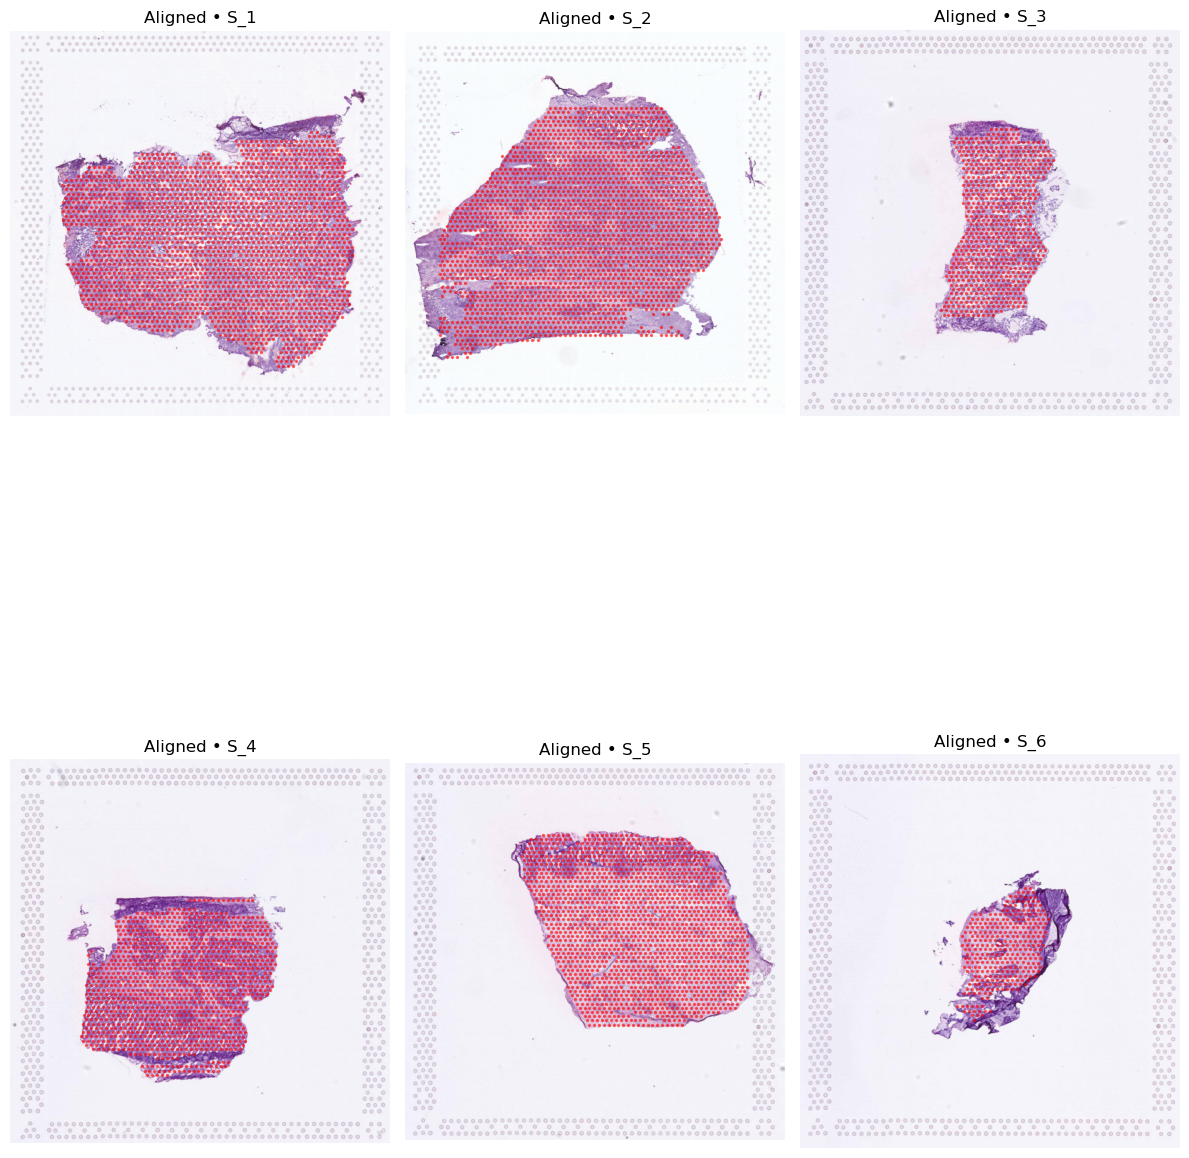

Loaded keys: dict_keys(['source_idx', 'tile', 'label', 'subtiles', 'slide_idx'])
Samples: 8349


In [5]:
import torch
import numpy as np
from torch.utils.data import Dataset
from python_scripts.operate_model import get_model_inputs
from python_scripts.import_data import convert_item
# assume convert_item and get_model_inputs are already defined
# assume convert_item and get_model_inputs are already defined

import torch
import numpy as np
from torch.utils.data import Dataset

# assume convert_item and get_model_inputs are already defined

class importDataset(Dataset):
    def __init__(self, data_dict, model, image_keys=None, transform=None, print_sig=False):
        self.data = data_dict
        self.image_keys = set(image_keys) if image_keys is not None else set()
        self.transform = transform if transform is not None else lambda x: x
        self.forward_keys = list(get_model_inputs(model, print_sig=print_sig).parameters.keys())

        # Check consistent lengths
        expected_length = None
        for key, value in self.data.items():
            if expected_length is None:
                expected_length = len(value)
            if len(value) != expected_length:
                raise ValueError(f"Field '{key}' length {len(value)} != expected {expected_length}")

        # Ensure forward keys and label exist
        for key in self.forward_keys:
            if key not in self.data:
                raise ValueError(f"Missing required field '{key}' for model forward")
        if 'label' not in self.data:
            raise ValueError("Missing 'label' field in data_dict")

    def __len__(self):
        return len(next(iter(self.data.values())))

    def __getitem__(self, idx):
        sample = {}
        # model inputs
        for key in self.forward_keys:
            value = self.data[key][idx]
            value = self.transform(value)
            if key in self.image_keys:
                tensor = convert_item(value, is_image=True)
            else:
                tensor = convert_item(value, is_image=False)
            sample[key] = tensor.float()

        # label
        label = self.transform(self.data['label'][idx])
        sample['label'] = convert_item(label, is_image=False).float()

                # slide_idx
                # slide_idx as raw
        if 'slide_idx' in self.data:
            sid = self.data['slide_idx'][idx]
            sample['slide_idx'] = sid

        return sample

    def check_item(self, idx=0, num_lines=5):
        # unchanged
        pass



def load_node_feature_data(pt_path: str, model, num_cells: int = 35) -> dict:
    """
    Ê†πÊçÆ model.forward ÁöÑÂèÇÊï∞Ëá™Âä®Âä†ËΩΩ .pt ÈáåÂØπÂ∫îÁöÑÂ≠óÊÆµÔºå
    Âπ∂‰∏îÂ¶ÇÊûúÊ≤°Êúâ labelÔºåÂ∞±Ëá™Âä®ÂàõÂª∫‰∏Ä‰∏™ÂÖ® 0 ÁöÑ label Âº†ÈáèÔºå
    ÂÖ∂Â∞∫ÂØ∏‰∏∫ (Ê†∑Êú¨Êï∞, num_cells)ÔºåÊ†∑Êú¨Êï∞‰ªéÁ¨¨‰∏Ä‰∏™Êúâ __len__ ÁöÑËæìÂÖ•Êé®Êñ≠„ÄÇ

    ÂèÇÊï∞Ôºö
      pt_path:     strÔºå.pt Êñá‰ª∂Ë∑ØÂæÑ
      model:       Â∑≤ÂÆû‰æãÂåñÁöÑ PyTorch Ê®°Âûã
      num_cells:   intÔºålabel ÁöÑÂàóÊï∞ÔºàÈªòËÆ§ 35Ôºâ

    ËøîÂõûÔºö
      dict: key ÂØπÂ∫îÊ®°Âûã forward ‰∏≠ÁöÑÂèÇÊï∞ÂêçÔºà‰∏çÂê´ selfÔºâÔºå
            value ÊòØÂØπÂ∫îÁöÑ Tensor/ndarrayÔºå
            Âπ∂È¢ùÂ§ñ‰øùËØÅÊúâ 'label' Â≠óÊÆµ„ÄÇ
    """
    # 1) ËΩΩÂÖ•ÂéüÂßãÊï∞ÊçÆ
    raw = torch.load(pt_path, map_location="cpu")

    # 2) ÂèñÊ®°Âûã forward ÂÖ•ÂèÇÁ≠æÂêçÔºà‰∏çÂê´ selfÔºâ
    sig = inspect.signature(model.forward)
    param_names = [p for p in sig.parameters if p != "self"]

    out = {}
    for name in param_names:
        # a) Áõ¥Êé•ÂêåÂêç
        if name in raw:
            out[name] = raw[name]
            continue
        # b) Â§çÊï∞ÂΩ¢Âºè
        if name + "s" in raw:
            out[name] = raw[name + "s"]
            continue
        # c) Ê®°Á≥äÂåπÈÖçÔºà‰∏ãÂàíÁ∫ø„ÄÅÂ§çÊï∞ÊàñÂâçÂêéÁºÄÔºâ
        cands = [k for k in raw if name in k or k in name]
        if len(cands) == 1:
            out[name] = raw[cands[0]]
            continue
        raise KeyError(f"Êó†Ê≥ïÊâæÂà∞ '{name}' Âú® pt Êñá‰ª∂‰∏≠ÁöÑÂØπÂ∫îÂ≠óÊÆµÔºåraw keys: {list(raw.keys())}")

    # 3) Áî®Á¨¨‰∏Ä‰∏™ÊîØÊåÅ len() ÁöÑËæìÂÖ•Êé®Êñ≠Ê†∑Êú¨Êï∞
    dataset_size = None
    for v in out.keys():
        if hasattr(out[v], "__len__"):
            dataset_size = len(out[v])
            print(f"‚ö†Ô∏è ‰ªé '{v}' Êé®Êñ≠Ê†∑Êú¨Êï∞Èáè: {dataset_size}")
            break
    if dataset_size is None:
        raise RuntimeError("Êó†Ê≥ï‰ªé‰ªª‰ΩïËæìÂÖ•‰∏≠Êé®Êñ≠Ê†∑Êú¨Êï∞ÈáèÔºåËØ∑Ê£ÄÊü• pt Êñá‰ª∂ÂÜÖÂÆπ„ÄÇ")

    # 4) Ëá™Âä®Ë°• label

    out["label"] = torch.zeros((dataset_size, num_cells), dtype=torch.float32)
        # 5) Ë°• slide_idxÔºåÂÖ®ÈÉΩÊ†á‰∏∫ "S_7"
    out["slide_idx"] = ["S_7"] * dataset_size
    return out


In [8]:
import torch
import inspect
from python_scripts.operate_model import get_model_inputs



image_keys = [ 'tile', 'subtiles']


# Áî®Ê≥ïÁ§∫‰æã
# ÂÅáËÆæ‰Ω†ÁöÑ model Â∑≤ÁªèÂÆö‰πâÂ•ΩÂπ∂ÂÆû‰æãÂåñ‰∏∫ `model`
test_dataset = load_node_feature_data("dataset/spot-rank/filtered_directly_rank/masked/test/Macenko/test_dataset.pt", model)


# Êää test_data_dict ÈáåÊâÄÊúâ ndarray / tensor ÈÉΩËΩ¨Êàê list
for key, val in test_dataset.items():
    print(key, type(val))
    # Â¶ÇÊûúÊòØ torch.Tensor
    if isinstance(val, torch.Tensor):
        test_dataset[key] = val.cpu().tolist()
    # Â¶ÇÊûúÊòØ numpy.ndarray
    elif isinstance(val, np.ndarray):
        test_dataset[key] = val.tolist()
    # Âê¶ÂàôÁïôÁùÄÔºàÊØîÂ¶Ç slide_idx Êú¨Ë∫´Â∞±ÊòØ listÔºâ

# ÁÑ∂ÂêéÁªü‰∏ÄÁî® list + list
combined = {}
for key, train_vals in test_dataset.items():
    if key in test_dataset:
        combined[key] = train_vals + grouped_data[key]
    else:
        combined[key] = train_vals


# ÊúÄÂêéÊûÑÈÄ† Dataset
image_keys = ['tile','subtiles']
full_dataset = importDataset(
    data_dict   = combined,
    model       = model,
    image_keys  = image_keys,
    transform   = lambda x: x,
    print_sig   = True
)

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_62186/1794571483.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(pt_path, map_location="cpu"

‚ö†Ô∏è ‰ªé 'tile' Êé®Êñ≠Ê†∑Êú¨Êï∞Èáè: 2088
tile <class 'list'>
subtiles <class 'list'>
label <class 'torch.Tensor'>
slide_idx <class 'list'>
Model forward signature: (tile, subtiles)


In [5]:
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import Subset, DataLoader
from python_scripts.aug         import augment_grouped_data, identity, subset_grouped_data
repeats = 0
slide_idxs = []
BATCH_SIZE = 64
for i in range(len(full_dataset)):
    slide_idxs.append(full_dataset[i]["slide_idx"])  # ÊàñËÄÖ "slide_name"

# ÂÅö‰∏ÄÊ¨° 80/20 ÁöÑ train/val ÂàíÂàÜÔºåÊåâ slide ÂàÜÂ±Ç
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X=range(len(full_dataset)),
                                     y=[0]*len(full_dataset),
                                     groups=slide_idxs))

all_data = {}
# ÂèñÁ¨¨‰∏Ä‰∏™ sample ÁöÑ key ÂàóË°®
sample0 = full_dataset[0]
for key in sample0.keys():
    all_data[key] = [ full_dataset[i][key] for i in range(len(full_dataset)) ]


train_base = subset_grouped_data(all_data, train_idx)
print("Starting augmenting...")

train_ds = augment_grouped_data(
                grouped_data=train_base,
                image_keys=['tile','subtiles'],
                repeats=repeats   # ÊØîÂ¶ÇÂØπÊØèÂº†ÂÅö 2 Ê¨°Â¢ûÂº∫
            )
print("Starting importDataset...")
# 1) ÂéüÂßã dataset
train_ds = importDataset(train_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)


    # 3) validation raw
val_ds     = subset_grouped_data(all_data, val_idx)
val_ds     = importDataset(val_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)

print("Starting DataLoader...")
    # 4) DataLoader ‰∏çÂÜçÂãïÊÖãÂ¢ûÂº∑
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=0, pin_memory=False)


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Starting augmenting...
Starting importDataset...
Starting DataLoader...


In [8]:
from python_scripts.import_data import importDataset

image_keys = [ 'tile', 'subtiles']

train_dataset = importDataset(
        data_dict=grouped_data,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )

Model forward signature: (tile, subtiles)


In [49]:

from torch.utils.data import random_split
from torch.utils.data import DataLoader

# Ë®≠ÂÆöÊØî‰æã
train_ratio = 0.8
val_ratio = 1 - train_ratio
total_len = len(train_dataset)
train_len = int(train_ratio * total_len)
val_len = total_len - train_len

# ÊãÜÂàÜ Dataset
generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(train_dataset, [train_len, val_len], generator=generator)

print(f"‚úÖ Train: {len(train_set)} samples")
print(f"‚úÖ Val: {len(val_set)} samples")

# üîπ Â∞áÂÖ∂ÂåÖÊàê DataLoader
BATCH_SIZE = 64

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)


‚úÖ Train: 6678 samples
‚úÖ Val: 1670 samples


In [38]:
device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

Start training


Epoch 01/20  Train Loss: 0.0181  Val Loss: 0.0115


Epoch 02/20  Train Loss: 0.0101  Val Loss: 0.0102


Epoch 03/20  Train Loss: 0.0091  Val Loss: 0.0089


Epoch 04/20  Train Loss: 0.0089  Val Loss: 0.0090


Epoch 05/20  Train Loss: 0.0085  Val Loss: 0.0089


Epoch 06/20  Train Loss: 0.0080  Val Loss: 0.0082


Epoch 07/20  Train Loss: 0.0078  Val Loss: 0.0076


Epoch 08/20  Train Loss: 0.0077  Val Loss: 0.0075


Epoch 09/20  Train Loss: 0.0074  Val Loss: 0.0073


Epoch 10/20  Train Loss: 0.0074  Val Loss: 0.0073


Epoch 11/20  Train Loss: 0.0072  Val Loss: 0.0072


Epoch 12/20  Train Loss: 0.0073  Val Loss: 0.0072


Epoch 13/20  Train Loss: 0.0072  Val Loss: 0.0072


Epoch 14/20  Train Loss: 0.0071  Val Loss: 0.0069


Epoch 15/20  Train Loss: 0.0069  Val Loss: 0.0068


Epoch 16/20  Train Loss: 0.0069  Val Loss: 0.0069


Epoch 17/20  Train Loss: 0.0068  Val Loss: 0.0067


Epoch 18/20  Train Loss: 0.0065  Val Loss: 0.0066


Epoch 19/20  Train Loss: 0.0065  Val Loss: 0.0068


Epoch 20/20  Train Loss: 0.0065  Val Loss: 0.0065


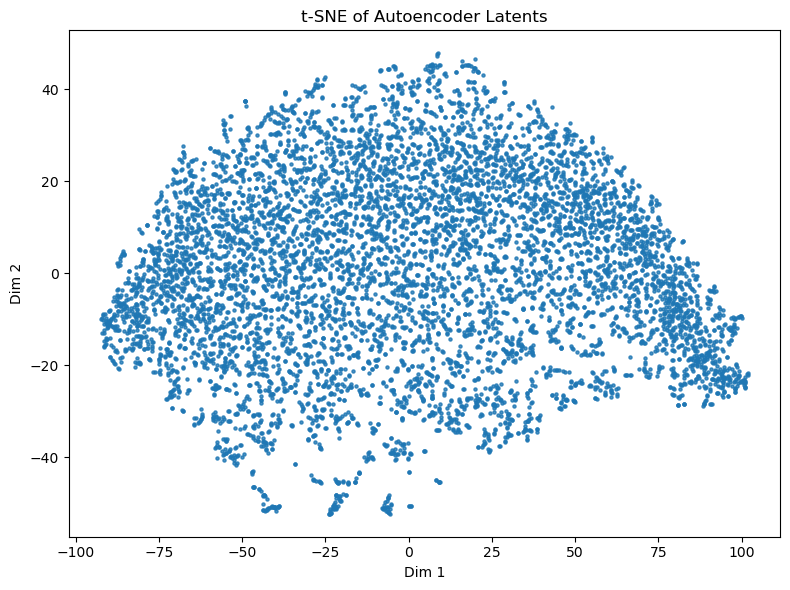

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm   # ‚Üê Êñ∞Â¢û
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

save_root = "AE_model/"
os.makedirs(save_root, exist_ok=True)

def train_autoencoder(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device,
    n_epochs: int = 20,
    lr: float = 1e-3
):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')

    for epoch in range(1, n_epochs+1):
        ## ‚Äî‚Äî‚Äî ËÆ≠ÁªÉÈò∂ÊÆµ ‚Äî‚Äî‚Äî
        model.train()
        train_loss = 0.0
        # tqdm(train_loader) ‰ºöÊòæÁ§∫ batch ËøõÂ∫¶Êù°
        loop = tqdm(train_loader, desc=f"Epoch {epoch}/{n_epochs} [Train]", leave=False)
        for batch in loop:
            tiles    = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)
            recon    = model(tiles, subtiles)
            target   = subtiles[:, 4]
            loss     = criterion(recon, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * tiles.size(0)
            loop.set_postfix(train_loss=train_loss / ((loop.n+1)*tiles.size(0)))

        train_loss /= len(train_loader.dataset)

        ## ‚Äî‚Äî‚Äî È™åËØÅÈò∂ÊÆµ ‚Äî‚Äî‚Äî
        model.eval()
        val_loss = 0.0
        loop = tqdm(val_loader, desc=f"Epoch {epoch}/{n_epochs} [Valid]", leave=False)
        with torch.no_grad():
            for batch in loop:
                tiles    = batch['tile'].to(device)
                subtiles = batch['subtiles'].to(device)
                recon    = model(tiles, subtiles)
                target   = subtiles[:, 4]
                loss     = criterion(recon, target)

                val_loss += loss.item() * tiles.size(0)
                loop.set_postfix(val_loss=val_loss / ((loop.n+1)*tiles.size(0)))

        val_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch:02d}/{n_epochs:02d}  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

        # ‰øùÂ≠òÊúÄ‰ºò
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(save_root, "best_autoencoder.pt"))

    # Âä†ËΩΩÊúÄ‰ºòÊùÉÈáç
    model.load_state_dict(torch.load(os.path.join(save_root, "best_autoencoder.pt")))
    return model

# ËÆ≠ÁªÉË∞ÉÁî®‰øùÊåÅ‰∏çÂèò
device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = ConvAutoencoder(center_dim=64, neighbor_dim=64, hidden_dim=128)
print("Start training")
model = train_autoencoder(model, train_loader, val_loader, device, n_epochs=20, lr=1e-3)

In [18]:
import torch
import numpy as np
from torch.utils.data import Dataset
from python_scripts.operate_model import get_model_inputs
from python_scripts.import_data import convert_item
# assume convert_item and get_model_inputs are already defined
# assume convert_item and get_model_inputs are already defined

import torch
import numpy as np
from torch.utils.data import Dataset

# assume convert_item and get_model_inputs are already defined

class importDataset(Dataset):
    def __init__(self, data_dict, model, image_keys=None, transform=None, print_sig=False):
        self.data = data_dict
        self.image_keys = set(image_keys) if image_keys is not None else set()
        self.transform = transform if transform is not None else lambda x: x
        self.forward_keys = list(get_model_inputs(model, print_sig=print_sig).parameters.keys())

        # Check consistent lengths
        expected_length = None
        for key, value in self.data.items():
            if expected_length is None:
                expected_length = len(value)
            if len(value) != expected_length:
                raise ValueError(f"Field '{key}' length {len(value)} != expected {expected_length}")

        # Ensure forward keys and label exist
        for key in self.forward_keys:
            if key not in self.data:
                raise ValueError(f"Missing required field '{key}' for model forward")
        if 'label' not in self.data:
            raise ValueError("Missing 'label' field in data_dict")

    def __len__(self):
        return len(next(iter(self.data.values())))

    def __getitem__(self, idx):
        sample = {}
        # model inputs
        for key in self.forward_keys:
            value = self.data[key][idx]
            value = self.transform(value)
            if key in self.image_keys:
                tensor = convert_item(value, is_image=True)
            else:
                tensor = convert_item(value, is_image=False)
            sample[key] = tensor.float()

        # label
        label = self.transform(self.data['label'][idx])
        sample['label'] = convert_item(label, is_image=False).float()

                # slide_idx
                # slide_idx as raw
        if 'slide_idx' in self.data:
            sid = self.data['slide_idx'][idx]
            sample['slide_idx'] = sid

        return sample

    def check_item(self, idx=0, num_lines=5):
        # unchanged
        pass



def load_node_feature_data(pt_path: str, model, num_cells: int = 35) -> dict:
    """
    Ê†πÊçÆ model.forward ÁöÑÂèÇÊï∞Ëá™Âä®Âä†ËΩΩ .pt ÈáåÂØπÂ∫îÁöÑÂ≠óÊÆµÔºå
    Âπ∂‰∏îÂ¶ÇÊûúÊ≤°Êúâ labelÔºåÂ∞±Ëá™Âä®ÂàõÂª∫‰∏Ä‰∏™ÂÖ® 0 ÁöÑ label Âº†ÈáèÔºå
    ÂÖ∂Â∞∫ÂØ∏‰∏∫ (Ê†∑Êú¨Êï∞, num_cells)ÔºåÊ†∑Êú¨Êï∞‰ªéÁ¨¨‰∏Ä‰∏™Êúâ __len__ ÁöÑËæìÂÖ•Êé®Êñ≠„ÄÇ

    ÂèÇÊï∞Ôºö
      pt_path:     strÔºå.pt Êñá‰ª∂Ë∑ØÂæÑ
      model:       Â∑≤ÂÆû‰æãÂåñÁöÑ PyTorch Ê®°Âûã
      num_cells:   intÔºålabel ÁöÑÂàóÊï∞ÔºàÈªòËÆ§ 35Ôºâ

    ËøîÂõûÔºö
      dict: key ÂØπÂ∫îÊ®°Âûã forward ‰∏≠ÁöÑÂèÇÊï∞ÂêçÔºà‰∏çÂê´ selfÔºâÔºå
            value ÊòØÂØπÂ∫îÁöÑ Tensor/ndarrayÔºå
            Âπ∂È¢ùÂ§ñ‰øùËØÅÊúâ 'label' Â≠óÊÆµ„ÄÇ
    """
    # 1) ËΩΩÂÖ•ÂéüÂßãÊï∞ÊçÆ
    raw = torch.load(pt_path, map_location="cpu")

    # 2) ÂèñÊ®°Âûã forward ÂÖ•ÂèÇÁ≠æÂêçÔºà‰∏çÂê´ selfÔºâ
    sig = inspect.signature(model.forward)
    param_names = [p for p in sig.parameters if p != "self"]

    out = {}
    for name in param_names:
        # a) Áõ¥Êé•ÂêåÂêç
        if name in raw:
            out[name] = raw[name]
            continue
        # b) Â§çÊï∞ÂΩ¢Âºè
        if name + "s" in raw:
            out[name] = raw[name + "s"]
            continue
        # c) Ê®°Á≥äÂåπÈÖçÔºà‰∏ãÂàíÁ∫ø„ÄÅÂ§çÊï∞ÊàñÂâçÂêéÁºÄÔºâ
        cands = [k for k in raw if name in k or k in name]
        if len(cands) == 1:
            out[name] = raw[cands[0]]
            continue
        raise KeyError(f"Êó†Ê≥ïÊâæÂà∞ '{name}' Âú® pt Êñá‰ª∂‰∏≠ÁöÑÂØπÂ∫îÂ≠óÊÆµÔºåraw keys: {list(raw.keys())}")

    # 3) Áî®Á¨¨‰∏Ä‰∏™ÊîØÊåÅ len() ÁöÑËæìÂÖ•Êé®Êñ≠Ê†∑Êú¨Êï∞
    dataset_size = None
    for v in out.keys():
        if hasattr(out[v], "__len__"):
            dataset_size = len(out[v])
            print(f"‚ö†Ô∏è ‰ªé '{v}' Êé®Êñ≠Ê†∑Êú¨Êï∞Èáè: {dataset_size}")
            break
    if dataset_size is None:
        raise RuntimeError("Êó†Ê≥ï‰ªé‰ªª‰ΩïËæìÂÖ•‰∏≠Êé®Êñ≠Ê†∑Êú¨Êï∞ÈáèÔºåËØ∑Ê£ÄÊü• pt Êñá‰ª∂ÂÜÖÂÆπ„ÄÇ")

    # 4) Ëá™Âä®Ë°• label

    out["label"] = torch.zeros((dataset_size, num_cells), dtype=torch.float32)
        # 5) Ë°• slide_idxÔºåÂÖ®ÈÉΩÊ†á‰∏∫ "S_7"
    out["slide_idx"] = ["S_7"] * dataset_size
    return out


In [19]:
import torch
import inspect
from python_scripts.operate_model import get_model_inputs



image_keys = [ 'tile', 'subtiles']


# Áî®Ê≥ïÁ§∫‰æã
# ÂÅáËÆæ‰Ω†ÁöÑ model Â∑≤ÁªèÂÆö‰πâÂ•ΩÂπ∂ÂÆû‰æãÂåñ‰∏∫ `model`
test_dataset = load_node_feature_data("dataset/spot-rank/filtered_directly_rank/masked/test/hed_normalize_image/test_dataset.pt", model)


# Êää test_data_dict ÈáåÊâÄÊúâ ndarray / tensor ÈÉΩËΩ¨Êàê list
for key, val in test_dataset.items():
    print(key, type(val))
    # Â¶ÇÊûúÊòØ torch.Tensor
    if isinstance(val, torch.Tensor):
        test_dataset[key] = val.cpu().tolist()
    # Â¶ÇÊûúÊòØ numpy.ndarray
    elif isinstance(val, np.ndarray):
        test_dataset[key] = val.tolist()
    # Âê¶ÂàôÁïôÁùÄÔºàÊØîÂ¶Ç slide_idx Êú¨Ë∫´Â∞±ÊòØ listÔºâ

# ÁÑ∂ÂêéÁªü‰∏ÄÁî® list + list
combined = {}
for key, train_vals in test_dataset.items():
    if key in test_dataset:
        combined[key] = train_vals + grouped_data[key]
    else:
        combined[key] = train_vals


# ÊúÄÂêéÊûÑÈÄ† Dataset
image_keys = ['tile','subtiles']
full_dataset = importDataset(
    data_dict   = combined,
    model       = model,
    image_keys  = image_keys,
    transform   = lambda x: x,
    print_sig   = True
)

‚ö†Ô∏è ‰ªé 'tile' Êé®Êñ≠Ê†∑Êú¨Êï∞Èáè: 2088
tile <class 'list'>
subtiles <class 'list'>
label <class 'torch.Tensor'>
slide_idx <class 'list'>
Model forward signature: (tile, subtiles)


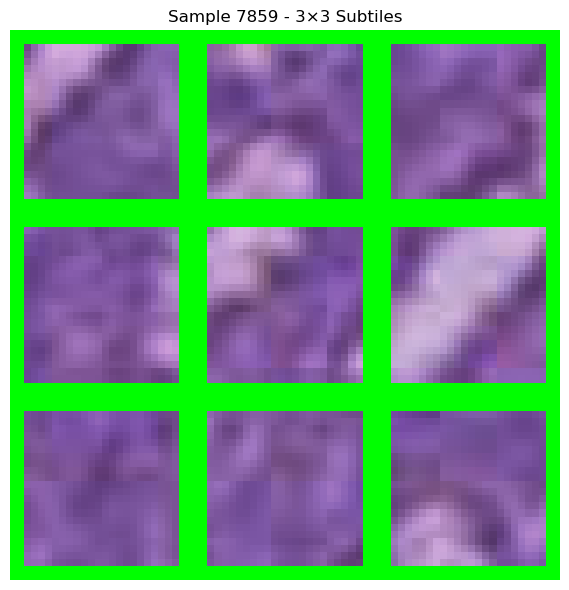

: 

In [ ]:
from python_scripts.validate_input import visualize_random_from_grouped_data

visualize_random_from_grouped_data(combined, subtile_grid_size=3)

In [1]:
model = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = False
    )

    # 2) monkey‚Äêpatch ‰∏Ä‰∏™Êñ∞ÁöÑ head
model.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = model.to(device)
model.load_state_dict(torch.load('output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold_mixed/realign_all/hed_normalize_image_masked/fold0/best_model.pt', map_location="cpu"))
model.to(device).eval()

NameError: name 'PretrainedEncoderRegressor' is not defined

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


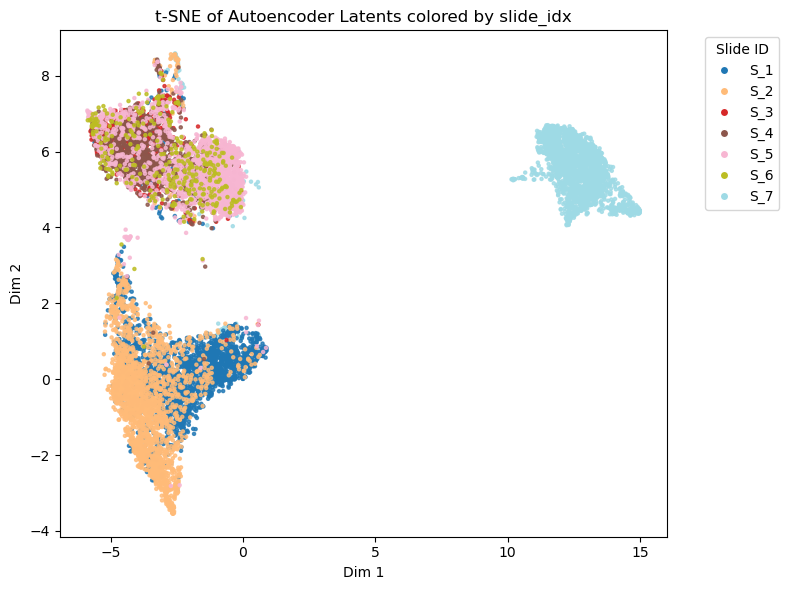

In [21]:
# 2) ÊèêÂèñÊΩúÂú®ÂêëÈáè & ÂØπÂ∫îÁöÑ slide_idx
#model.eval()
latents = []
slide_ids = []

with torch.no_grad():
    for batch in DataLoader(full_dataset, batch_size=64, shuffle=False):
        # ÁâπÂæÅÈÉ®ÂàÜ‰∏çÂèò
        tiles    = batch['tile'].to(device)
        subtiles = batch['subtiles'].to(device)

        center   = subtiles[:,4]
        f_c      = model.enc_center(center)
        f_n      = model.enc_neigh(subtiles)
        fuse     = torch.cat([f_c, f_n], dim=1)
        h        = fuse

        latents.append(h.cpu())

        # ËøôÈáå‰∏çË¶Å .numpy()ÔºåÁõ¥Êé• extend ÂàóË°®
        sids = batch['slide_idx']   # ËøôÊòØ‰∏Ä‰∏™ list
        slide_ids.extend(sids)

# ÊúÄÂêéËΩ¨Êàê numpy array
latents   = torch.cat(latents, dim=0).numpy()
slide_ids = np.array(slide_ids)


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE

# latents, slide_ids Â∑≤ÁªèÂáÜÂ§áÂ•Ω
unique_slides, slide_codes = np.unique(slide_ids, return_inverse=True)

# tsne = TSNE(n_components=2, random_state=42)
# proj = tsne.fit_transform(latents)
import umap

proj = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42) \
               .fit_transform(latents) 
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    proj[:,0], proj[:,1],
    c=slide_codes,
    cmap='tab20',
    s=5, alpha=0.8
)

# Ëá™ÂÆö‰πâÂõæ‰æã
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=scatter.cmap(scatter.norm(code)),
           markersize=6,
           label=slide_name)
    for code, slide_name in enumerate(unique_slides)
]

plt.legend(
    handles=legend_elements,
    title="Slide ID",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.title("t-SNE of Autoencoder Latents colored by slide_idx")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()



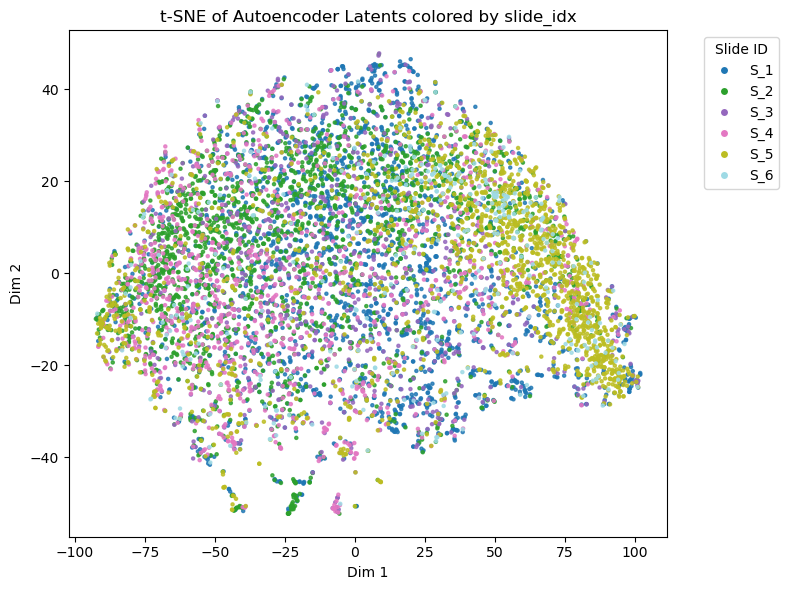

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE

# latents, slide_ids Â∑≤ÁªèÂáÜÂ§áÂ•Ω
unique_slides, slide_codes = np.unique(slide_ids, return_inverse=True)

tsne = TSNE(n_components=2, random_state=42)
proj = tsne.fit_transform(latents)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    proj[:,0], proj[:,1],
    c=slide_codes,
    cmap='tab20',
    s=5, alpha=0.8
)

# Ëá™ÂÆö‰πâÂõæ‰æã
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=scatter.cmap(scatter.norm(code)),
           markersize=6,
           label=slide_name)
    for code, slide_name in enumerate(unique_slides)
]

plt.legend(
    handles=legend_elements,
    title="Slide ID",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.title("t-SNE of Autoencoder Latents colored by slide_idx")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()


# Spot ÈôçÁ∂≠

In [81]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# 1) ÂÆö‰πâ‰∏Ä‰∏™ÁÆÄÂçïÁöÑ Tabular Autoencoder
class TabularAutoencoder(nn.Module):
    def __init__(self, input_dim=35, latent_dim=8):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# 2) Â∞ÅË£Ö Dataset
class SpotDataset(Dataset):
    def __init__(self, matrix: np.ndarray):
        """
        matrix: shape (N_spots, 35)ÔºåÈ¢ÑÂ§ÑÁêÜÂêéÁöÑÁâπÂæÅÁü©Èòµ
        """
        self.data = torch.from_numpy(matrix).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 3) ËÆ≠ÁªÉÂáΩÊï∞
def train_autoencoder(
    data_matrix: np.ndarray,
    latent_dim: int = 8,
    batch_size: int = 64,
    lr: float = 1e-3,
    n_epochs: int = 50,
    device: str = "cpu"
):
    ds = SpotDataset(data_matrix)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    model = TabularAutoencoder(input_dim=data_matrix.shape[1], latent_dim=latent_dim)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(1, n_epochs+1):
        model.train()
        tot_loss = 0.0
        for batch in loader:
            batch = batch.to(device)
            recon, _ = model(batch)
            loss = criterion(recon, batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tot_loss += loss.item() * batch.size(0)
        tot_loss /= len(ds)
        if epoch % 10 == 0 or epoch==1:
            print(f"Epoch {epoch}/{n_epochs}  Recon MSE: {tot_loss:.4f}")
    return model


# Data

In [82]:
import h5py
import numpy as np
import pandas as pd
from scipy.stats import rankdata

# -----------------------------------------------------
# Step 1: ËÆÄÂèñ HDF5 ‰∏≠ Train slide ÁöÑ spot Ë≥áÊñôÔºå‰∏¶‰ª• slide ÂêçÁ®±Âª∫Á´ã DataFrame Â≠óÂÖ∏
# -----------------------------------------------------
#with h5py.File("dataset/filtered&masked_dataset.h5", "r") as f:

with h5py.File("dataset/realign/filtered_dataset.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"‚úÖ Â∑≤ËÆÄÂèñ slide: {slide_name}")

# -----------------------------------------------------
# Step 2: Âêà‰ΩµÊâÄÊúâ slide ÁöÑË≥áÊñô
# -----------------------------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)

if "slide_name" not in all_train_spots_df.columns:
    all_train_spots_df["slide_name"] = all_train_spots_df.index.map(lambda i: "unknown")

# -----------------------------------------------------
# Step 3: Â∞çÊØè‰∏ÄÂÄã spot ÁöÑ cell abundances ÈÄ≤Ë°åÊéíÂêç
# -----------------------------------------------------
cell_type_cols = [col for col in all_train_spots_df.columns if col.startswith("C")]

# Âª∫Á´ã‰∏ÄÂÄãÊñ∞ÁöÑ DataFrame ÂÑ≤Â≠òÊéíÂêçË≥áË®ä
ranked_df = all_train_spots_df.copy()

# Â∞çÊØè‰∏ÄË°åÂÅöÊéíÂêçÔºàaxis=1Ôºâ
ranked_values = all_train_spots_df[cell_type_cols].apply(
    lambda row: rankdata(row.values, method="ordinal"), axis=1, result_type='expand'
)
# ÂéüÂßã abundance | ÊéíÂêç (ordinal)
# ÊúÄÂ§ßÂÄº | ÊúÄÂ§ß rankÔºàÊï∏Â≠ó ÊúÄÂ§ßÔºâ
# ÊúÄÂ∞èÂÄº | 1

# Áî® "rank_" + ÂéüÊú¨Ê¨Ñ‰ΩçÂêçÁ®±
ranked_values.columns = [f"rank_{col}" for col in cell_type_cols]

# ÂÜçÂíåÂéüË≥áÊñôÂêà‰Ωµ
ranked_df = pd.concat([ranked_df.drop(columns=cell_type_cols), ranked_values], axis=1)

‚úÖ Â∑≤ËÆÄÂèñ slide: S_1
‚úÖ Â∑≤ËÆÄÂèñ slide: S_2
‚úÖ Â∑≤ËÆÄÂèñ slide: S_3
‚úÖ Â∑≤ËÆÄÂèñ slide: S_4
‚úÖ Â∑≤ËÆÄÂèñ slide: S_5
‚úÖ Â∑≤ËÆÄÂèñ slide: S_6


## original_log2_z_score_rank

In [83]:

# suppose `ranked_df` has columns rank_C1‚Ä¶rank_C35 plus slide_name
cell_cols = [f"C{i}" for i in range(1,36)]
original_log2_z_score = all_train_spots_df.copy()

# per‚Äêslide zscore
# ‰πãÂêéÂÜçÂÅö scaled„ÄÅlog2_coeff„ÄÅwranks Â∞±Âíå‰πãÂâç‰∏ÄÊ†∑
original_log2_z_score[cell_cols] = np.log2(original_log2_z_score[cell_cols])
                  
# 1) ËÆ°ÁÆóÊØè‰∏™ slide ÁöÑÂÖ®Â±Ä mean & std
slide_stats = (
    original_log2_z_score
    .groupby("slide_name")[cell_cols]
    .apply(lambda sub: pd.Series({
        "slide_mean": sub.values.flatten().mean(),
        "slide_std":  sub.values.flatten().std()
    }))
    .reset_index()
)

# 2) ÊääËøô‰∏§‰∏™Â≠óÊÆµ merge ÂõûÂéü df
original_log2_z_score = original_log2_z_score.merge(slide_stats, on="slide_name", how="left")

# 3) Áî®Âêå‰∏ÄÁªÑ slide_mean/slide_std ÂÅöÂΩí‰∏ÄÂåñ
original_log2_z_score[cell_cols] = (original_log2_z_score[cell_cols] - original_log2_z_score["slide_mean"].values[:, None]) \
                / original_log2_z_score["slide_std"].values[:, None]

# ÔºàÂèØÈÄâÔºâÂà†Êéâ‰∏¥Êó∂Âàó
original_log2_z_score.drop(columns=["slide_mean","slide_std"], inplace=True)

original_log2_z_score[cell_cols] = original_log2_z_score[cell_cols] - original_log2_z_score[cell_cols].min().min() +1

# suppose `ranked_df` has columns rank_C1‚Ä¶rank_C35 plus slide_name
cell_cols = [f"C{i}" for i in range(1,36)]
original_log2_z_score_rank = original_log2_z_score.copy()
rank_cols = [f"rank_C{i}" for i in range(1,36)]
# per‚Äêslide zscore
# ‰πãÂêéÂÜçÂÅö scaled„ÄÅlog2_coeff„ÄÅwranks Â∞±Âíå‰πãÂâç‰∏ÄÊ†∑
# ÂÅáËÆæ original_log2_z_score_rank Âíå ranked_df Âú®Ë°åÈ°∫Â∫è‰∏äÊòØÂØπÂ∫îÁöÑ
orig_vals = original_log2_z_score_rank[cell_cols].to_numpy()   # shape (N,35)
rank_vals = ranked_df      [rank_cols].to_numpy()              # shape (N,35)

# ÈÄêÂÖÉÁ¥†Áõ∏‰πò
new_vals = orig_vals * rank_vals

# ËµãÂõû DataFrame
original_log2_z_score_rank[cell_cols] = new_vals



## df_log2_ranks

In [84]:
##df_log2_ranks


cell_cols = [f"C{i}" for i in range(1,36)]
rank_cols = [f"rank_C{i}" for i in range(1,36)]

# 1) ËÆ°ÁÆóÊØè‰∏™ slide ÁöÑÊúÄÂ∞èË°®ËææÔºàË∑®ÊâÄÊúâ spots„ÄÅÊâÄÊúâ cell typesÔºâ
slide_min = (
    all_train_spots_df
    .groupby('slide_name')[cell_cols]    # cell_cols = ['C1','C2',‚Ä¶,'C35']
    .min()                               # ÂæóÂà∞ DataFrame: index=slide_name, columns=cell_cols
    .min(axis=1)                         # ÂÜçÂØπ cell_cols axis=1 ÂèñÊúÄÂ∞è -> Series, index=slide_name
)

# 2) ÊääËøô‰∏™ slide ÊúÄÂ∞èÂÄºÊò†Â∞ÑÂõûÊØè‰∏ÄË°å
min_expr = (
    all_train_spots_df['slide_name']
    .map(slide_min)                      # Series ÈïøÂ∫¶ N
    .values
    .reshape(-1, 1)                      # ÂèòÊàê (N,1)
)



expr  = all_train_spots_df[cell_cols].values    # (N,35)
ranks = ranked_df[rank_cols].values             # (N,35)
df_log2_ranks = ranked_df.copy()

# ‰πãÂêéÂÜçÂÅö scaled„ÄÅlog2_coeff„ÄÅwranks Â∞±Âíå‰πãÂâç‰∏ÄÊ†∑
scaled     = expr / min_expr * 2
log2_coeff = np.log2(scaled)
wranks     = log2_coeff * ranks
# Áõ¥Êé•ÊõøÊç¢ ranked_df ‰∏≠ÁöÑ rank Âàó
for i, col in enumerate(rank_cols):
    df_log2_ranks[col] = wranks[:, i]



## Train 

In [ ]:
# 4) ÂáÜÂ§á‰∏çÂêåÈ¢ÑÂ§ÑÁêÜÁöÑÊï∞ÊçÆ
#    ÂÅáËÆæ all_spots: ÂéüÂßãË°®ËææÁü©Èòµ shape (N,35)

cell_cols = [f"C{i}" for i in range(1,36)]
rank_cols = [f"rank_C{i}" for i in range(1,36)]
data_A = original_log2_z_score_rank[cell_cols].values  # raw counts or log2 etc.
data_B = df_log2_ranks[rank_cols].values  # raw counts or log2 etc.


# 5) ÂàÜÂà´ËÆ≠ÁªÉ
device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Training Autoencoder on raw log2 ‚Ä¶")
ae_A = train_autoencoder(data_A, latent_dim=8, n_epochs=50, device=device)
print("Training Autoencoder on per-slide min-max ‚Ä¶")
ae_B = train_autoencoder(data_B, latent_dim=8, n_epochs=50, device=device)
print("Training Autoencoder on quantile uniform ‚Ä¶")

# 6) ÊèêÂèñÊâÄÊúâ latent ÂêëÈáèÔºåÂÅö UMAP ÂèØËßÜÂåñ
import umap
def get_latents(ae, data):
    with torch.no_grad():
        z = ae.encoder(torch.from_numpy(data).float().to(device))
        return z.cpu().numpy()

latents_A = get_latents(ae_A, data_A)
latents_B = get_latents(ae_B, data_B)

reducer = umap.UMAP(random_state=42)
emb_A = reducer.fit_transform(latents_A)
emb_B = reducer.fit_transform(latents_B)

# ÁªòÂõæÂØπÊØî
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3,figsize=(12,4))
for emb, title, ax in zip([emb_A,emb_B],
                          ["raw log2","per-slide min-max","quantile"],
                          axs):
    ax.scatter(emb[:,0], emb[:,1], s=5, alpha=0.8)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()


Training Autoencoder on raw log2 ‚Ä¶
Epoch 1/50  Recon MSE: 7522.9334
Epoch 10/50  Recon MSE: 1137.7520
Epoch 20/50  Recon MSE: 938.9856
Epoch 30/50  Recon MSE: 874.9552
Epoch 40/50  Recon MSE: 846.5324
Epoch 50/50  Recon MSE: 799.9916
Training Autoencoder on per-slide min-max ‚Ä¶
Epoch 1/50  Recon MSE: 116698.3086
Epoch 10/50  Recon MSE: 16707.7757
Epoch 20/50  Recon MSE: 14942.4109
Epoch 30/50  Recon MSE: 13293.7931
Epoch 40/50  Recon MSE: 13040.7249
Epoch 50/50  Recon MSE: 12106.8598
Training Autoencoder on quantile uniform ‚Ä¶


NameError: name 'ae_C' is not defined

In [88]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def plot_umap_features(
    *,
    df: pd.DataFrame = None,
    latents: np.ndarray = None,
    feature_cols: list = None,
    latent_idxs: list = None,
    n_neighbors: int = 15,
    min_dist: float = 0.1,
    random_state: int = 42,
    cmap: str = "viridis",
    point_size: int = 5,
    alpha: float = 0.8,
    ncols: int = 7,
    uniform_cmap: bool = True
):
    """
    ÈÄöÁî® UMAP ÂèØËßÜÂåñÔºöÊîØÊåÅ DataFrame+feature_cols Êàñ Latent matrix+latent_idxs„ÄÇ

    ÂèÇÊï∞:
      df           : Â¶ÇÊûú‰Ω†Ë¶ÅÂèØËßÜÂåñ DataFrame ‰∏≠ÁöÑÂàóÔºå‰º†ÂÖ• df Âíå feature_colsÔºõ
      latents      : Â¶ÇÊûú‰Ω†Áõ¥Êé•Áî® latent ÂêëÈáèÔºåÂèØ‰º† latentsÔºàN√óDÔºâÂíå latent_idxsÔºàË¶Å‰∏äËâ≤ÁöÑÁª¥Â∫¶ÂàóË°®ÔºâÔºõ
      feature_cols : DataFrame ‰∏≠Ë¶ÅÂèØËßÜÂåñÁöÑÂàóÂêçÂàóË°®Ôºõ
      latent_idxs  : latent Êï∞ÁªÑ‰∏≠Ë¶ÅÂèØËßÜÂåñÁöÑÁª¥Â∫¶Á¥¢ÂºïÂàóË°®Ôºõ
      ÂÖ∂‰ΩôÂèÇÊï∞Âêå plot_all_rank_umaps„ÄÇ
    """
    # ÂáÜÂ§áË¶ÅÂèØËßÜÂåñÁöÑÁü©Èòµ X Âíå label arrays
    if df is not None and feature_cols is not None:
        X_in = df[feature_cols].values.astype(float)
        labels = {col: df[col].values for col in feature_cols}
        keys = feature_cols
    elif latents is not None and latent_idxs is not None:
        X_in = latents[:, latent_idxs].astype(float)
        labels = {f"latent_{i}": latents[:, i] for i in latent_idxs}
        keys = [f"latent_{i}" for i in latent_idxs]
    else:
        raise ValueError("ÂøÖÈ°ª‰º†ÂÖ• (df + feature_cols) Êàñ (latents + latent_idxs)„ÄÇ")

    # 1) UMAP ÈôçÁª¥
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )
    emb = reducer.fit_transform(X_in)
    umap1, umap2 = emb[:,0], emb[:,1]

    # 2) ËÆ°ÁÆó Spearman œÅÔºàUMAP1 vs ÊØè‰∏™ feature/latentÔºâ
    rhos = []
    for k in keys:
        rho, _ = spearmanr(umap1, labels[k])
        rhos.append(abs(rho))
    avg_rho = float(np.mean(rhos))
    print(f"Average abs(Spearman rho): {avg_rho:.3f}")

    # 3) ÂáÜÂ§áËâ≤Ê†áËåÉÂõ¥
    if uniform_cmap:
        all_vals = np.vstack([labels[k] for k in keys])
        vmin, vmax = all_vals.min(), all_vals.max()
    else:
        vmin = vmax = None

    # 4) ÁªòÂà∂ÁΩëÊ†ºÂõæ
    n_plots = len(keys)
    nrows = int(np.ceil(n_plots / ncols))
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(ncols*3, nrows*2.5),
                             sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, (k, rho) in zip(axes, zip(keys, rhos)):
        sc = ax.scatter(umap1, umap2,
                        c=labels[k],
                        cmap=cmap,
                        vmin=vmin, vmax=vmax,
                        s=point_size, alpha=alpha)
        ax.set_title(f"{k} (œÅ={rho:.2f})", fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
        plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

    # Âà†Èô§Â§ö‰ΩôÂ≠êÂõæ
    for ax in axes[n_plots:]:
        ax.remove()
    plt.tight_layout()
    plt.show()

    # 5) Êù°ÂΩ¢ÂõæÔºöÊâÄÊúâ rho ÂÄº
    rho_df = pd.DataFrame({
        "feature": keys,
        "rho": rhos
    }).set_index("feature")
    plt.figure(figsize=(ncols*0.8, nrows*0.6))
    rho_df["rho"].plot(kind="bar")
    plt.ylabel("abs(Spearman œÅ)")
    plt.axhline(0, color="k", linewidth=0.5)
    plt.title("Continuity along UMAP1")
    plt.tight_layout()
    plt.show()


In [94]:
list(range(latents_A[0]))

TypeError: only integer scalar arrays can be converted to a scalar index

In [91]:
plot_umap_features(
    latents=latents_A,      # shape (N, latent_dim)
    latent_idxs=list(range(latents_A[0])),  # ÊØîÂ¶Ç [0,1,2,3,‚Ä¶]
    ncols=4,                # Êåâ‰Ω†ÁöÑ latent_dim Ë∞ÉÊï¥ÁΩëÊ†º
    uniform_cmap=False
)

TypeError: only integer scalar arrays can be converted to a scalar index